In [1]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as np
import spacy
import glob
import os
from pathlib import Path

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st
import re

### textblob
from textblob import TextBlob

In [2]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### countvectorizer, tfidfvectorizer, embeddings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import umap.umap_ as umap

import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, Trainer, TrainingArguments, pipeline
import umap

### gpu
#device = torch.device("npu:0") 
#tensor = torch.randn(3, 3).to(device) 
#print(tensor.device)
# 출력: npu:0

In [3]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### tqdm
from tqdm import tqdm

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

## 0. Embeddings Settings

In [4]:
# Load dataset
data_dir = Path(r"C:\Users\Hyemi\Python\TopicModeling\Data")
data_dir.mkdir(parents=True, exist_ok=True)
file_path = data_dir / "articles_tokenize.csv"
articles_full = pd.read_csv(file_path)

In [5]:
# Define a function to classify journals into groups
def classify_year_group(year):
    if 2013 <= year <= 2016:
        return "1"
    elif 2017 <= year <= 2019:
        return "2"
    elif 2020 <= year <= 2021:
        return "3"
    elif 2022 <= year <= 2024:
        return "4"
    else:
        return "5"

articles_full["Year_Group"] = articles_full["Year"].apply(classify_year_group)

# Load XLM-RoBERTa model and tokenizer
model_name = "xlm-roberta-large-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [6]:
def batch_get_embeddings(texts, model, tokenizer, batch_size=32):

    embeddings = []
    
    # Process texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                           return_tensors="pt", max_length=512)
        
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extract CLS token representations
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(batch_embeddings)
    
    # Combine all batch embeddings
    return np.vstack(embeddings)

## 3. Embedding: group3

In [7]:
import umap.umap_ as umap

# Modify the column assignment
df = articles_full[articles_full["Year_Group"] == "3"]
df["Embeddings"] = list(
    map(lambda x: x.tolist(), batch_get_embeddings(df["Abstract"].tolist(), model, tokenizer))
)

# Rest of the clustering code remains the same
embeddings_matrix = np.vstack(df["Embeddings"].values)
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings_matrix)

# Optional: Add progress tracking
print("Embedding generation complete. Shape:", embeddings_matrix.shape)

Generating Embeddings: 100%|███████████████████████████████████████████████████████| 222/222 [5:08:09<00:00, 83.29s/it]


Embedding generation complete. Shape: (7102, 1024)


In [23]:
import umap.umap_ as umap

umap_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = umap_3d.fit_transform(embeddings_matrix)

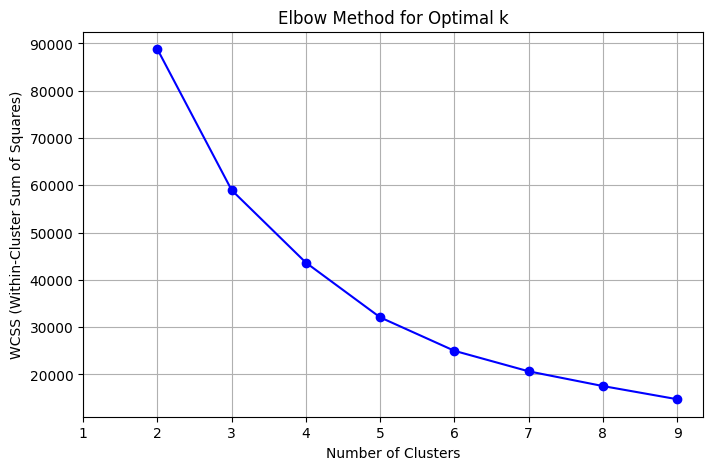

In [25]:
# Function to calculate the Within-Cluster Sum of Squares (WCSS) for different cluster sizes
def plot_elbow_method(embeddings_matrix, max_clusters=9):
    wcss = []  # List to store WCSS for each number of clusters
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
        kmeans.fit(embeddings_matrix)
        wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the closest centroid
    
    # Plot Elbow Graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal k")
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show()
    
# Run the Elbow Method function to determine the optimal number of clusters
plot_elbow_method(embeddings_2d)

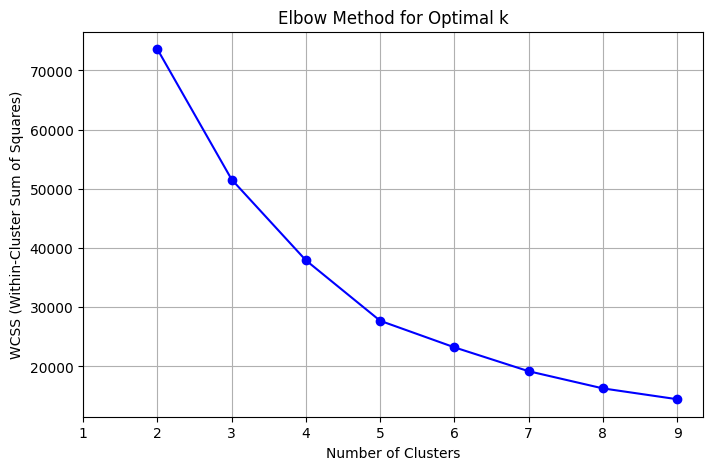

In [24]:
# Function to calculate the Within-Cluster Sum of Squares (WCSS) for different cluster sizes
def plot_elbow_method(embeddings_matrix, max_clusters=9):
    wcss = []  # List to store WCSS for each number of clusters
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
        kmeans.fit(embeddings_matrix)
        wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the closest centroid
    
    # Plot Elbow Graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal k")
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show()
    
# Run the Elbow Method function to determine the optimal number of clusters
plot_elbow_method(embeddings_3d)

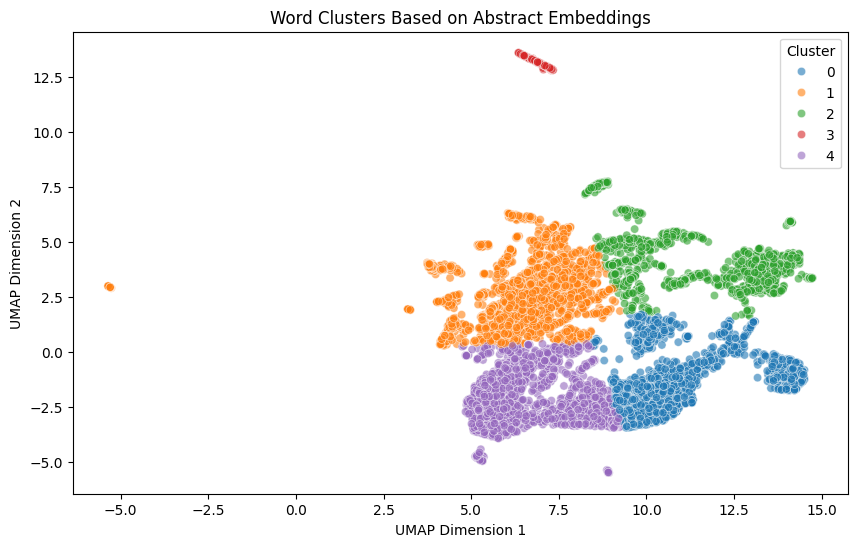

In [14]:
# Perform K-Means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=30)
clusters = kmeans.fit_predict(embeddings_2d)

# Add clustering results to the dataframe
# df["Cluster"] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=df["Cluster"], palette="tab10", alpha=0.6)
plt.title("Word Clusters Based on Abstract Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [26]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=100)
clusters = kmeans.fit_predict(embeddings_3d)  # Use 3D embeddings

df["Cluster3"] = clusters

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=100)
clusters = kmeans.fit_predict(embeddings_3d)  # Use 3D embeddings

df["Cluster4"] = clusters

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=100)
clusters = kmeans.fit_predict(embeddings_3d)  # Use 3D embeddings

df["Cluster5"] = clusters

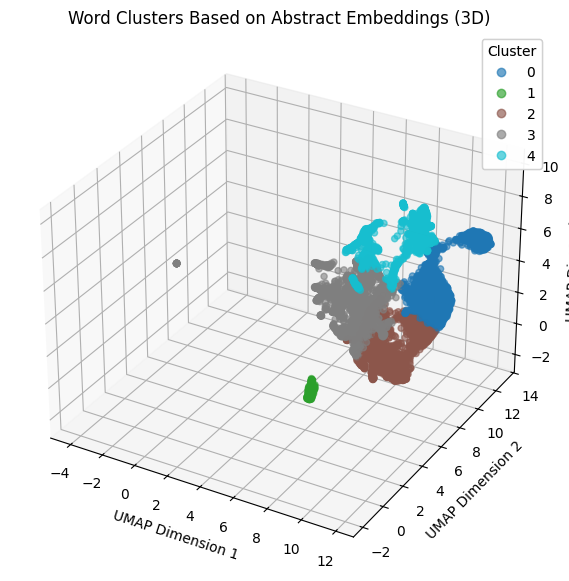

In [32]:
# Set number of clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=100)
clusters = kmeans.fit_predict(embeddings_3d)  # Use 3D embeddings

df["Cluster5"] = clusters

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], 
    c=df["Cluster5"], cmap="tab10", alpha=0.6
)

# Labels and Title
ax.set_title("Word Clusters Based on Abstract Embeddings (3D)")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

# Show plot
plt.show()


In [33]:
data_dir = Path(r"C:\Users\Hyemi\Python\TopicModeling\Data")
data_dir.mkdir(parents=True, exist_ok=True)

file_path = data_dir / "articles_embedding_3_full.csv"

df.to_csv(file_path, index=False)